# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

#### Set learning parameters

In [3]:
no_features = 77
no_hidden = 128
no_labels = 2

1.Define the model class.

In [5]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 80:20 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [9]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # splitting and scaling
    x_train, y_train, x_test, y_test = split_dataset(df, ['filename','label'], 0.2, set_seed())
    X_train_scaled, X_test_scaled = preprocess_dataset(x_train, x_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [13]:
class CustomDataset(Dataset):
    # create CustomDataset class
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y)
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # create CustomDataset objects for train and test data
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)
    # create DataLoader objects for train and test data
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

4.Next, define the model, optimizer and loss function.

In [19]:
# YOUR CODE HERE
model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [25]:
# train and test functions
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        train_correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
        
    train_loss /= size
    train_correct /= size
    
    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(dim=1)==y).type(torch.float).sum().item()

    test_loss /= size
    test_correct /= size

    return test_loss, test_correct

In [27]:
from common_utils import EarlyStopper
early_stopper = EarlyStopper(patience=3, min_delta=0)
no_epochs = 100

In [29]:
train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []

In [31]:
for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    
    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)

    print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_acc):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_acc):>0.2f}%, Test_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
        print("Done!")
        break

Epoch 1: Train_accuracy: 55.33%, Train_loss: 0.005402, Test_accuracy: 55.68%, Test_loss: 0.005378
Epoch 2: Train_accuracy: 59.17%, Train_loss: 0.005273, Test_accuracy: 58.50%, Test_loss: 0.005267
Epoch 3: Train_accuracy: 61.28%, Train_loss: 0.005165, Test_accuracy: 60.16%, Test_loss: 0.005212
Epoch 4: Train_accuracy: 63.75%, Train_loss: 0.005057, Test_accuracy: 61.48%, Test_loss: 0.005186
Epoch 5: Train_accuracy: 65.26%, Train_loss: 0.004961, Test_accuracy: 62.65%, Test_loss: 0.005103
Epoch 6: Train_accuracy: 66.48%, Train_loss: 0.004892, Test_accuracy: 63.72%, Test_loss: 0.005036
Epoch 7: Train_accuracy: 68.07%, Train_loss: 0.004791, Test_accuracy: 64.14%, Test_loss: 0.005022
Epoch 8: Train_accuracy: 70.18%, Train_loss: 0.004683, Test_accuracy: 64.93%, Test_loss: 0.005009
Epoch 9: Train_accuracy: 70.62%, Train_loss: 0.004638, Test_accuracy: 66.25%, Test_loss: 0.004932
Epoch 10: Train_accuracy: 71.85%, Train_loss: 0.004559, Test_accuracy: 65.84%, Test_loss: 0.004936
Epoch 11: Train_acc

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


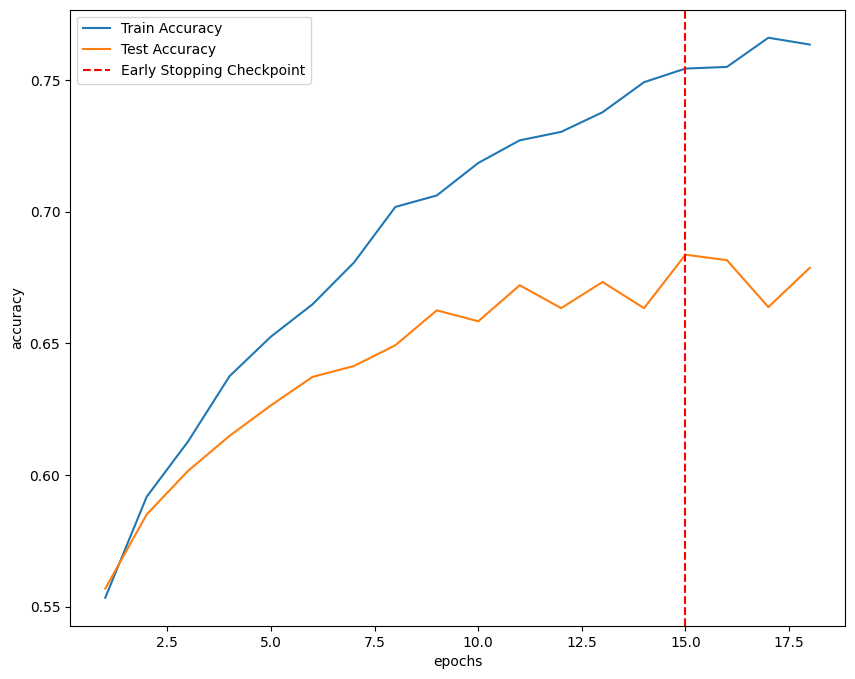

In [33]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc_)+1),train_acc_, label='Train Accuracy')
plt.plot(range(1,len(test_acc_)+1),test_acc_,label='Test Accuracy')

# find position of lowest test loss
minposs = test_loss_.index(min(test_loss_))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

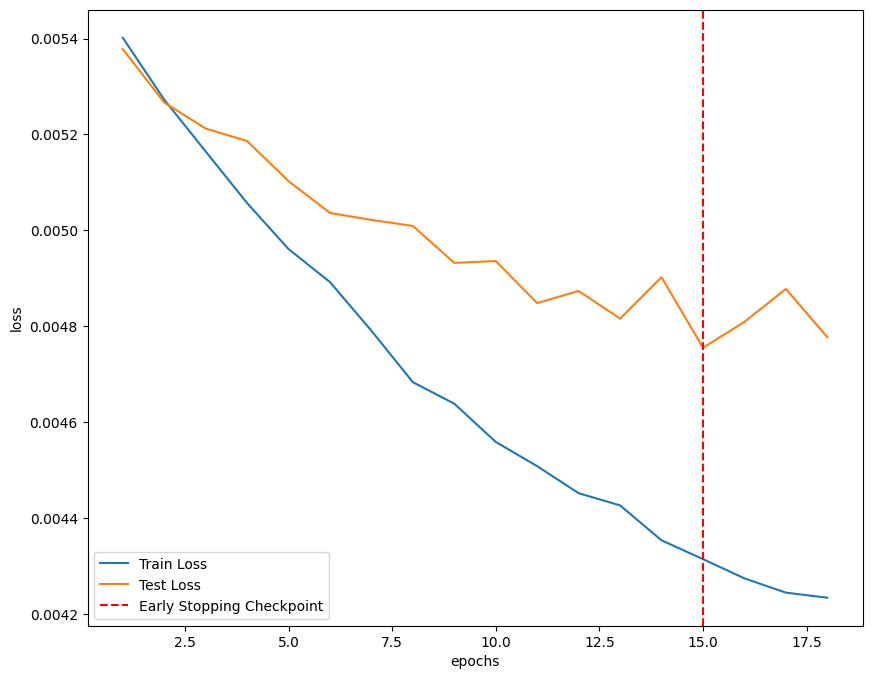

In [36]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss_)+1),train_loss_, label='Train Loss')
plt.plot(range(1,len(test_loss_)+1),test_loss_,label='Test Loss')

# find position of lowest test loss
minposs = test_loss_.index(min(test_loss_))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

6.Comment on line plots.

In [39]:
# YOUR CODE HERE
answer = "Early Stopping has shown that the model is just right at epoch 15. Even though training loss is lower and training accuracy is higher after epoch 15, the higher test loss for 3 consecutive epochs after epoch 15 indicates overfitting and the model possibly memorising the train set instead of learning and generalising. Therefore early stopping is used to prevent overtraining and it shows that the model at epoch 15 is just right for output prediction for test set."